In [46]:
import pandas as pd
import gensim
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import requests
import io
import numpy as np

### Load data files from Dataverse into Pandas dataframes

In [47]:
# authors data originally sourced from https://github.com/happygrammer/bible-metadata
authors_url = "https://demo.dataverse.org/api/access/datafile/:persistentId?persistentId=doi:10.70122/FK2/TWN24G/L9HGNJ"
# other data originally source from Kaggle
key_eng_url = "https://demo.dataverse.org/api/access/datafile/:persistentId?persistentId=doi:10.70122/FK2/TWN24G/HVQNTT"
genre_url = "https://demo.dataverse.org/api/access/datafile/:persistentId?persistentId=doi:10.70122/FK2/TWN24G/EMQAVG"
asv_url = "https://demo.dataverse.org/api/access/datafile/:persistentId?persistentId=doi:10.70122/FK2/TWN24G/JDJSJV"

response = requests.get(authors_url)
authors = pd.read_csv(io.StringIO(response.text), sep='\t')

response = requests.get(key_eng_url)
key = pd.read_csv(io.StringIO(response.text), sep='\t')

response = requests.get(genre_url)
genre = pd.read_csv(io.StringIO(response.text), sep='\t')

response = requests.get(asv_url)
asv = pd.read_csv(io.StringIO(response.text), sep=',')

### Data cleaning and aggregation
#### Clean author data
* Rename columns to make merging with Kaggle data easier
* Assume Solomon wrote all of the Proverbs and David wrote all of the Psalms
* Replace '-'s with "unknown"
* Remove underscore from "john_mark" and correct "obadiah" and "malachi" spelling
#### Merge author and kaggle dataframes into one singular df
* Merge ASV and key on book to get each book's genre number
* Merge result with genre to get text genre label
* Merge result with authors on book to get each book's author
* Rename columns for clarity

In [48]:
authors = authors[['en_author', 'idx']]
authors = authors.rename(columns={'idx': 'b', 'en_author': 'author'})
authors.loc[authors['b'] == 19, 'author'] = "david" # for simplicity, assume David wrote all of the Psalms
authors.loc[authors['b'] == 20, 'author'] = "solomon" # for simplicity, assume Solomon wrote all of Proverbs
authors.loc[authors['author'] == '-', 'author'] = "unknown" # replace "-" authors with unknown to be more explicit
authors.loc[authors['author'] == 'john_mark', 'author'] = "john mark"
authors.loc[authors['author'] == 'obdiah', 'author'] = "obadiah" # correct spelling mistakes
authors.loc[authors['author'] == 'malaki', 'author'] = "malachi" 

In [49]:
# merge ASV version with key df on book to get genre info
merged_data = pd.merge(asv, key, on='b')
# merge new df with genre df on genre to get text label of genre
merged_data = pd.merge(merged_data, genre, on='g')
# merge new df with authors df on book to get author info for each book
merged_data = pd.merge(merged_data, authors, on='b')

merged_data = merged_data.rename(columns={'t_x': 'text', 't_y': 'testament', 'b': 'book', 'c': 'chapter',
                                'v': 'verse', 'n_x': 'book name', 'n_y': 'genre name', 'g': 'genre'})

data = merged_data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31103 entries, 0 to 31102
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          31103 non-null  int64 
 1   book        31103 non-null  int64 
 2   chapter     31103 non-null  int64 
 3   verse       31103 non-null  int64 
 4   text        31103 non-null  object
 5   book name   31103 non-null  object
 6   testament   31103 non-null  object
 7   genre       31103 non-null  int64 
 8   genre name  31103 non-null  object
 9   author      31103 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.4+ MB
None


### Plot verse quantity per genre
History is the most common genre, while Apocalyptic is the least common.

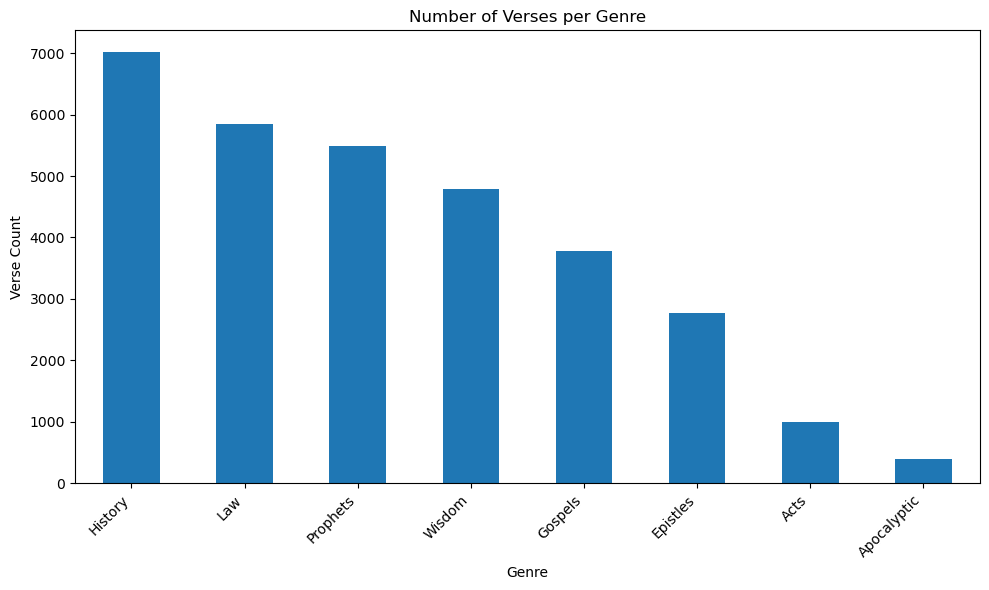

<Figure size 640x480 with 0 Axes>

In [50]:
genre_counts = data['genre name'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Verse Count')
plt.title('Number of Verses per Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/verses_per_genre.png')
plt.show()
plt.clf()

### Plot verse quantity per genre per Testament
The genres are not shared between the Old and New Testament. The OT genres are distributed pretty evenly, with Hisotry being the most frequent genre but a small margin. The NT is dominated by the Gospels.

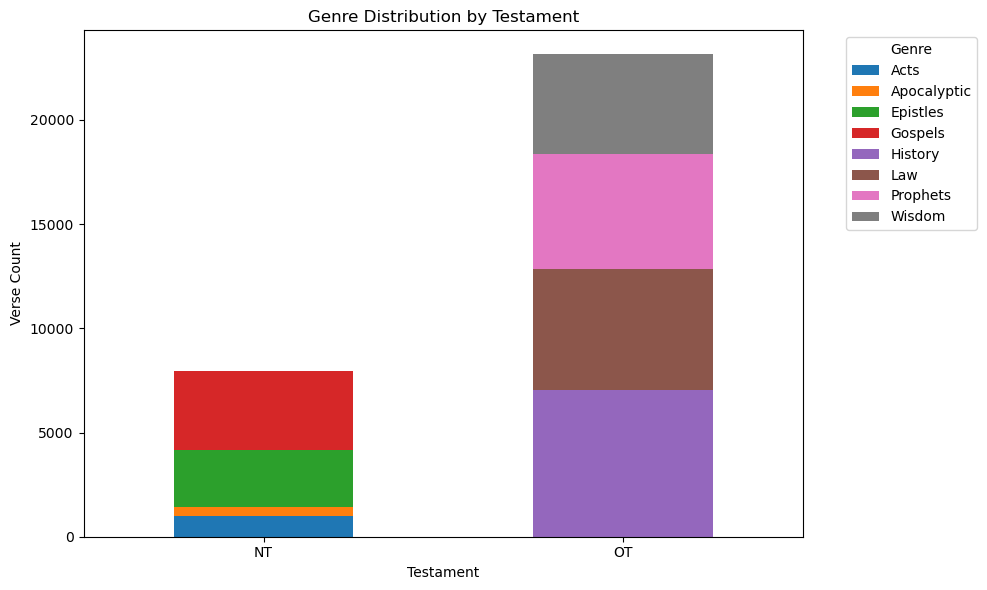

<Figure size 640x480 with 0 Axes>

In [51]:
testament_genre_counts = data.groupby(['testament', 'genre name']).size().unstack(fill_value=0)
testament_genre_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Testament')
plt.ylabel('Verse Count')
plt.title('Genre Distribution by Testament')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('figures/genres_per_testament.png')
plt.show()
plt.clf()

### Plot verse quantity per Author
Moses, David, and Luke wrote the most verses. Obadiah, Jude, and Haggai wrote the least.

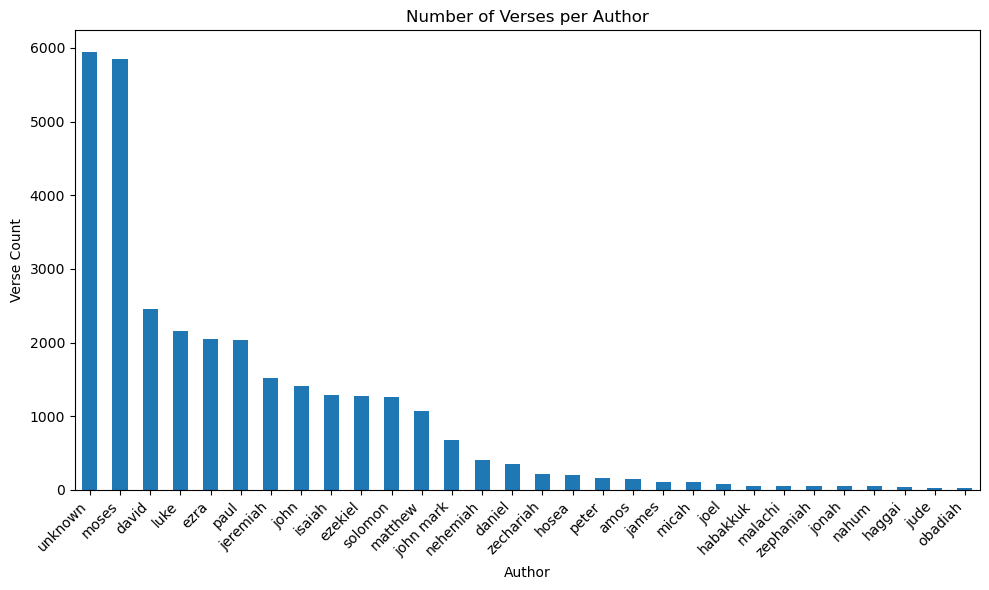

<Figure size 640x480 with 0 Axes>

In [52]:
genre_counts = data['author'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Author')
plt.ylabel('Verse Count')
plt.title('Number of Verses per Author')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/verses_per_author.png')
plt.show()
plt.clf()

### Plot frequencies for verse lengths
Most verses are around twenty words long.

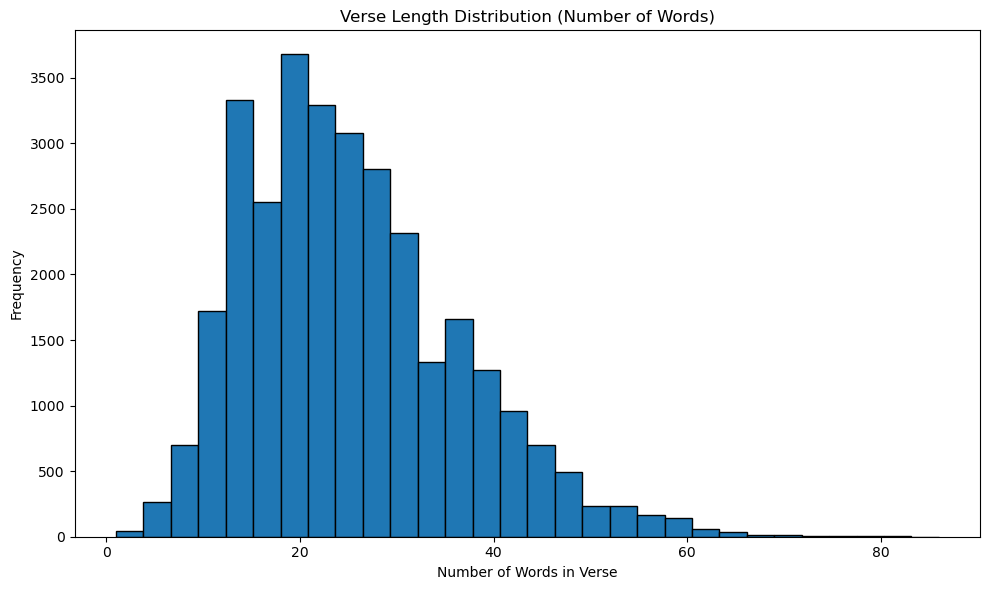

<Figure size 640x480 with 0 Axes>

In [53]:
data['number of words'] = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(data['number of words'], bins=30, edgecolor='black')
plt.xlabel('Number of Words in Verse')
plt.ylabel('Frequency')
plt.title('Verse Length Distribution (Number of Words)')
plt.tight_layout()
plt.savefig('figures/verses_len_distribution.png')
plt.show()
plt.clf()

In [9]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliasteed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliasteed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Find the most common words in each genre
* Combine all verses in the genre into a single string
* Tokenize words and remove stop words
* Count word frequency and plot

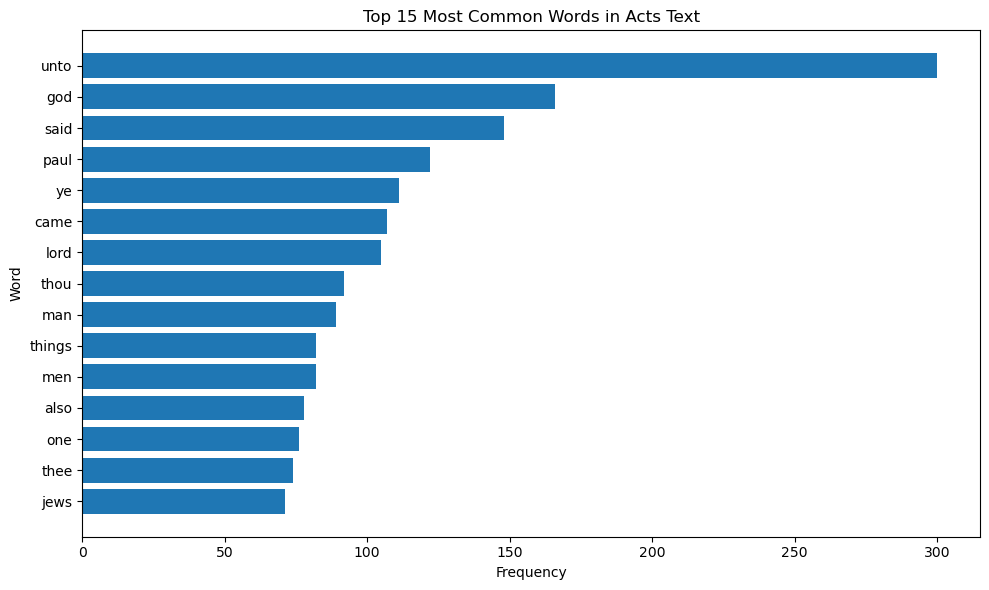

<Figure size 640x480 with 0 Axes>

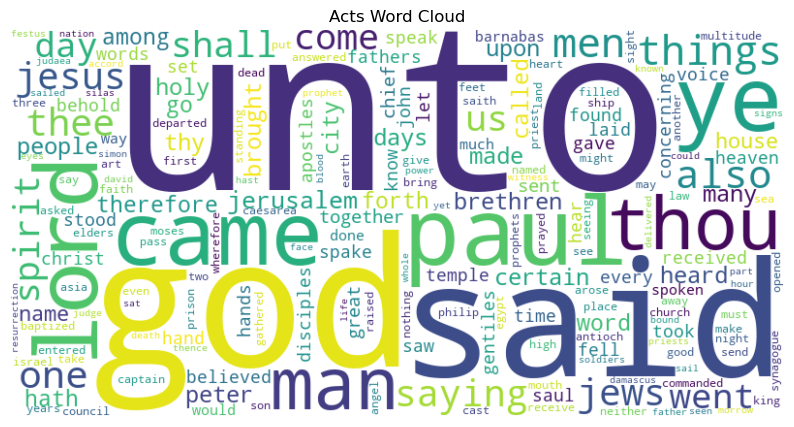

<Figure size 640x480 with 0 Axes>

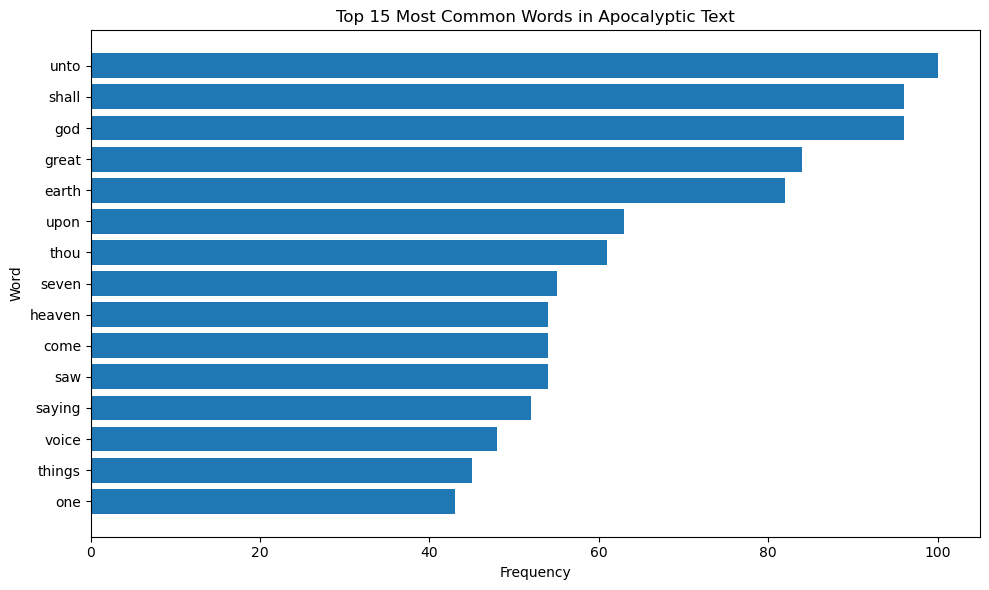

<Figure size 640x480 with 0 Axes>

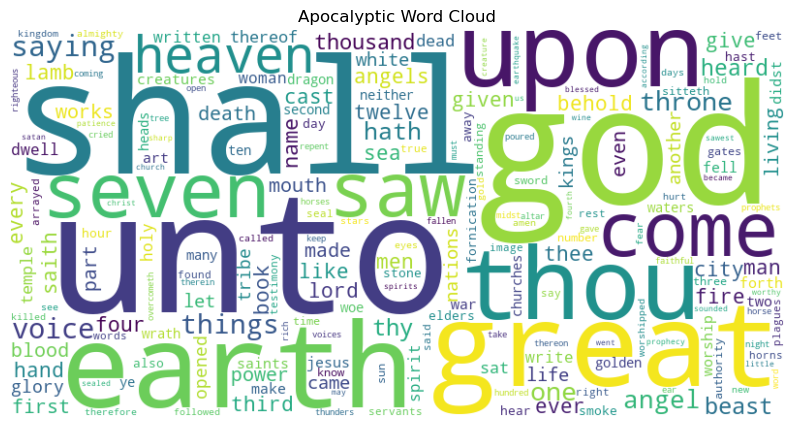

<Figure size 640x480 with 0 Axes>

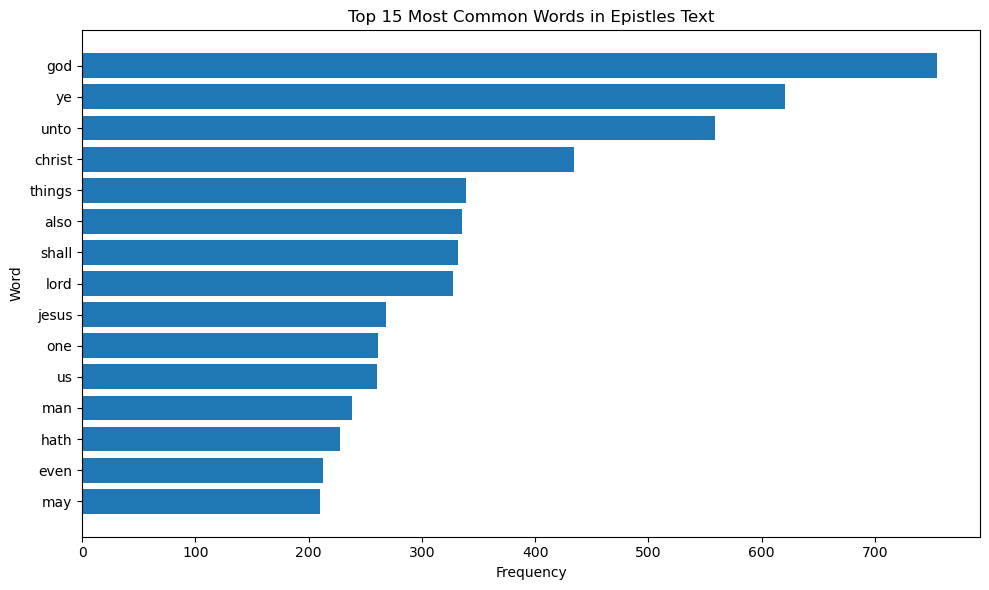

<Figure size 640x480 with 0 Axes>

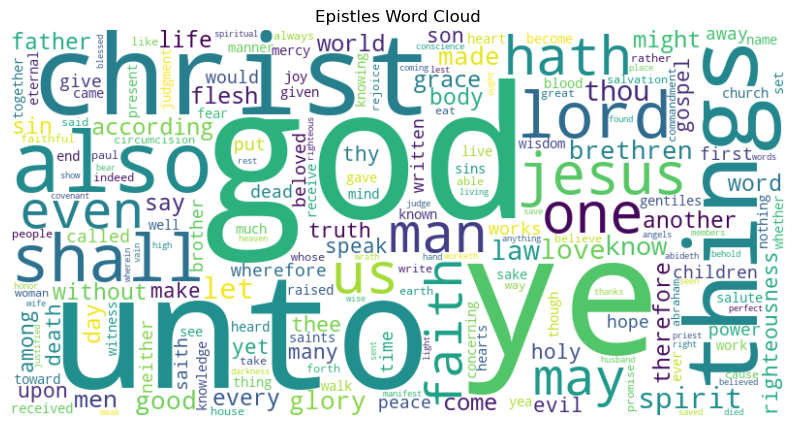

<Figure size 640x480 with 0 Axes>

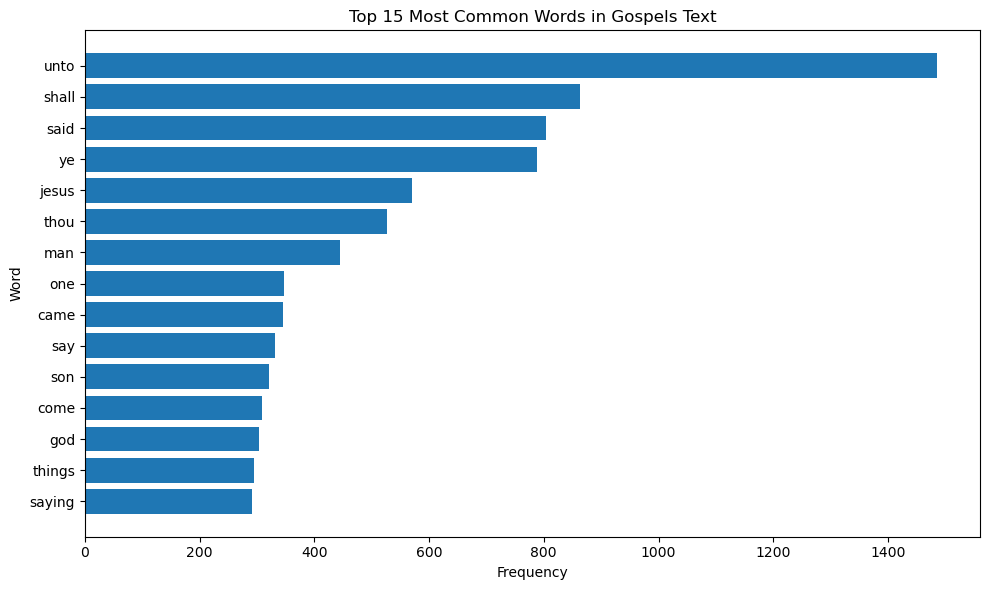

<Figure size 640x480 with 0 Axes>

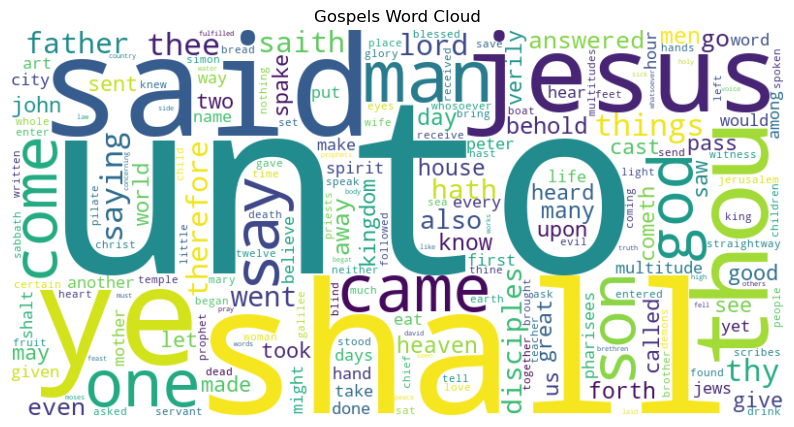

<Figure size 640x480 with 0 Axes>

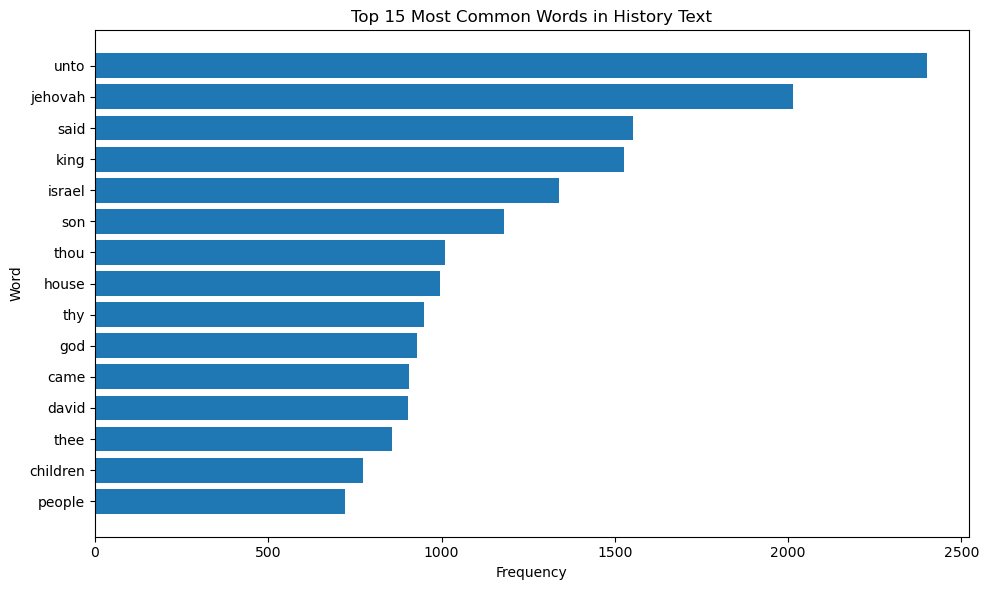

<Figure size 640x480 with 0 Axes>

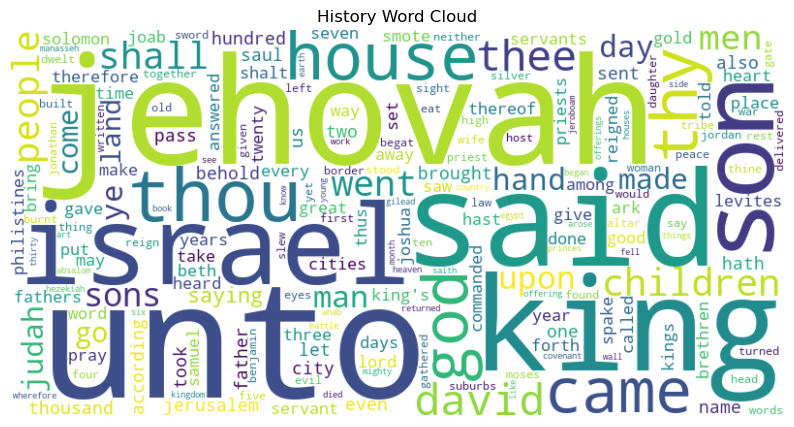

<Figure size 640x480 with 0 Axes>

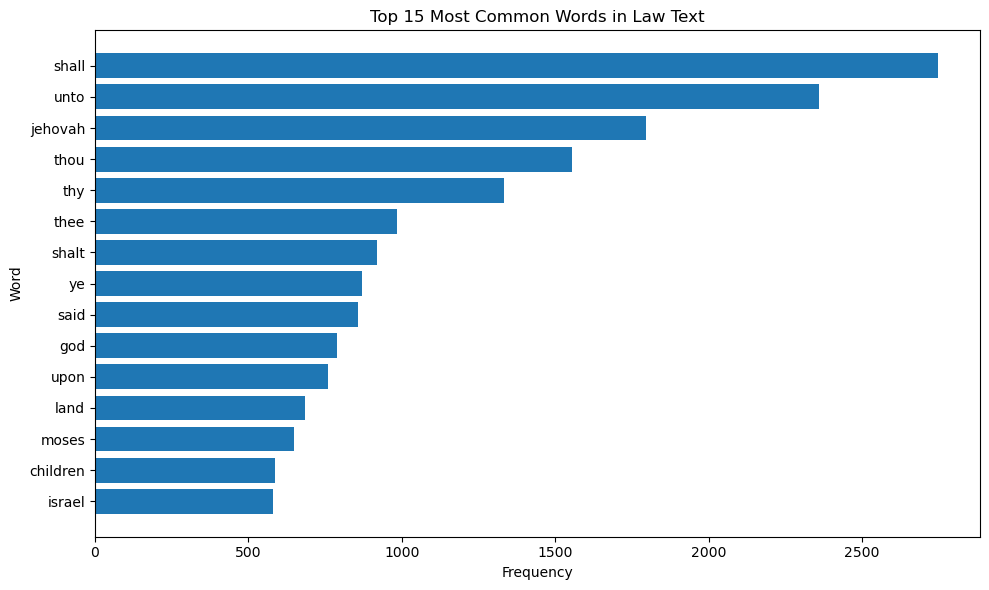

<Figure size 640x480 with 0 Axes>

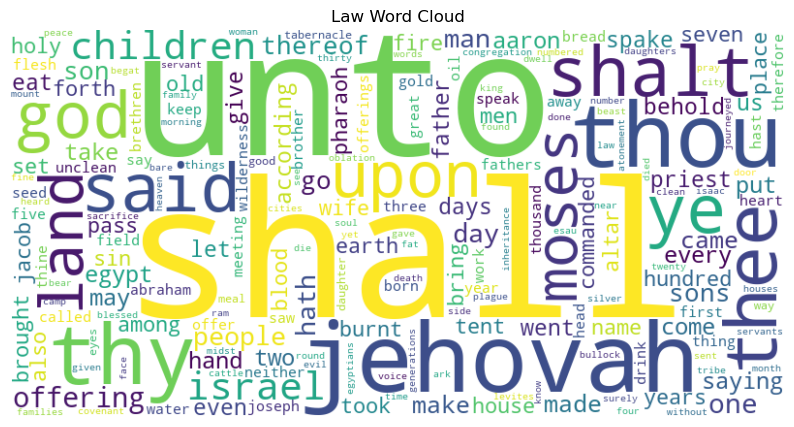

<Figure size 640x480 with 0 Axes>

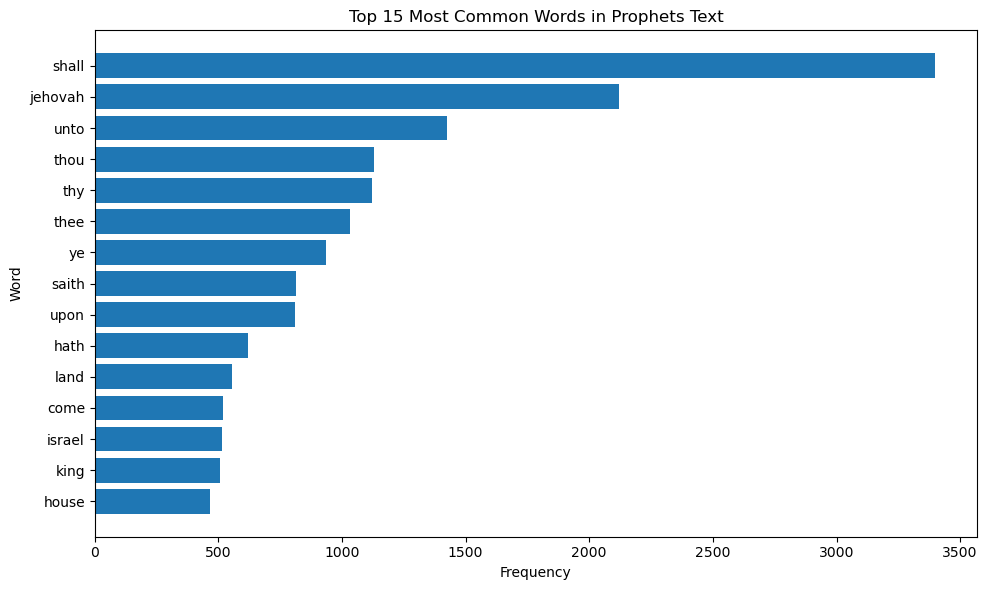

<Figure size 640x480 with 0 Axes>

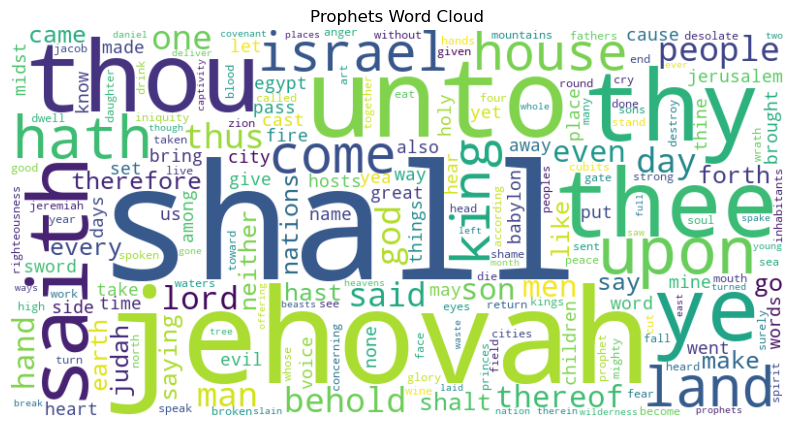

<Figure size 640x480 with 0 Axes>

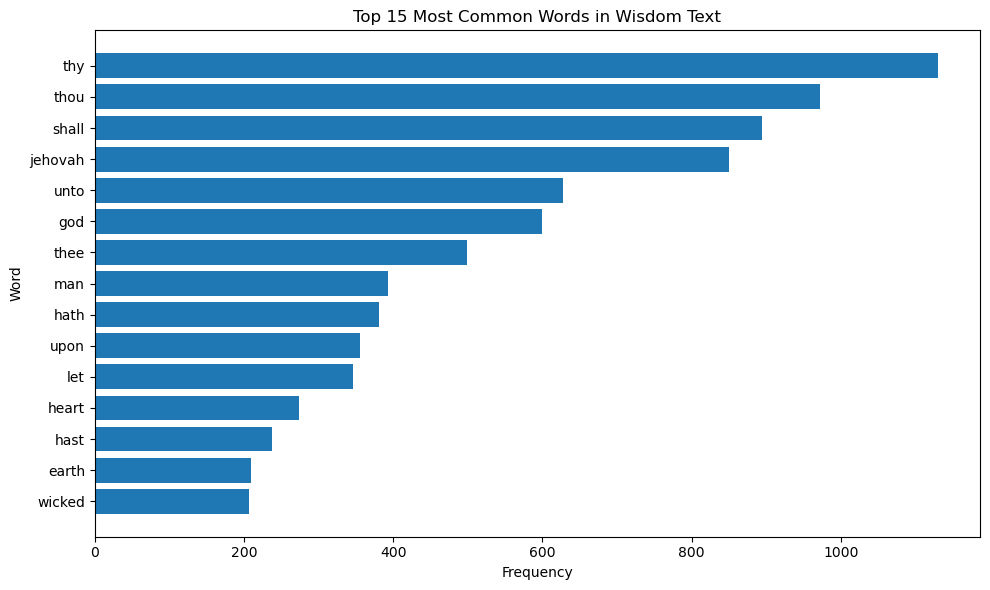

<Figure size 640x480 with 0 Axes>

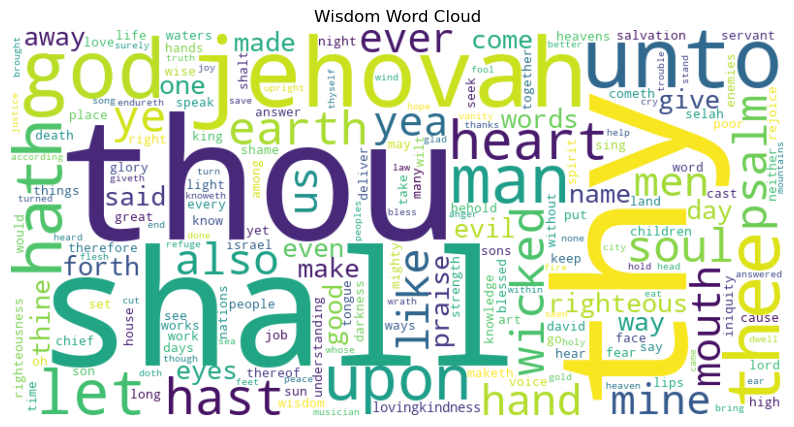

<Figure size 640x480 with 0 Axes>

In [54]:
def analyze_genre(genre_data, genre_name):
    # combine all text from verses in genre into a single string
    all_text = ' '.join(genre_data['text'])

    # handle apostrophes and tokenize text into words
    tokenizer = nltk.RegexpTokenizer(r"\w+(?:'\w+)?")  # Custom tokenizer to handle words with apostrophes
    words = tokenizer.tokenize(all_text)

    # remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.lower() not in stop_words
             and word.lower() not in string.punctuation]

    word_freq = Counter(words)
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

    # bar chart
    n = 15
    plt.figure(figsize=(10, 6))
    plt.barh(word_freq_df['Word'][:n], word_freq_df['Frequency'][:n])
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title(f'Top {n} Most Common Words in {genre_name} Text')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'figures/{genre_name}_top{n}.png')
    plt.show()
    plt.clf()

    # word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{genre_name} Word Cloud')
    plt.savefig(f'figures/{genre_name}_wordcloud.png')
    plt.show()
    plt.clf()

# group genre and plot more common words in each genre
for genre, genre_data in data.groupby('genre name'):
    analyze_genre(genre_data, genre)

#### Top 5 most common words in each genre
* Acts: "unto", "god", "said", "paul", "ye"
* Apocalyptic: "unto", "shall", "god", "great", "earth"
* Epistles: "god", "ye", "unto", "christ", "things"
* Gospels: "unto", "shall", "said", "ye", "jesus"
* History: "unto", "jehovah", "said", "king", "israel"
* Law: "shall", "unto", "jehovah", "thou", "thy"
* Prophets: "shall", "jehovah", "unto", "thou", "thy"
* Wisdom: "thy", "thou", "shall", "jehovah", "unto"

#### Observations
* "unto" is in the top 5 for every genre
* OT genres of Law, Prophets, and Wisdom have the same top 5 most common words, just rearranged
* OT primarily refers to God as Jehovah, while NT primarily refers to God as God
* "Jesus" is mentioned the most in the Gospels

### Predict Verse Genre
* Subsample data by genre
* Obtain two lists: one containing each verse and one containing their corresponding genres
* Tag verses by genre
* Train Doc2Vec model on tagged data
* Store verse vectors and corresponding genre tags in df
* Split data into train/test with 80-20 ratio, where features are verse vectors and labels are genres

In [55]:
backup_data = data

In [56]:
genre_counts = data['genre'].value_counts()
target_count = genre_counts.min()

sampled_data = pd.DataFrame(columns=data.columns)

for genre, count in genre_counts.items():
    if count > target_count:
        # if the genre is overrepresented, sample rows randomly
        sampled_rows = data[data['genre'] == genre].sample(target_count, random_state=42)
    else:
        # if the genre is already at or below the minimum count, use all rows
        sampled_rows = data[data['genre'] == genre]
    
    # concatenate the sampled rows
    sampled_data = pd.concat([sampled_data, sampled_rows])

sampled_data.reset_index(drop=True, inplace=True)

In [57]:
data = sampled_data

In [58]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               3232 non-null   object
 1   book             3232 non-null   object
 2   chapter          3232 non-null   object
 3   verse            3232 non-null   object
 4   text             3232 non-null   object
 5   book name        3232 non-null   object
 6   testament        3232 non-null   object
 7   genre            3232 non-null   object
 8   genre name       3232 non-null   object
 9   author           3232 non-null   object
 10  number of words  3232 non-null   object
dtypes: object(11)
memory usage: 277.9+ KB
None


In [59]:
# get list of verses and their corresponding genres
verses = data["text"].to_list()
genres = data["genre name"].tolist()

# remove punctuation from provided string
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

cleaned_verses = [remove_punctuation(verse) for verse in verses]

unique_genres = sorted(set(genres))

In [60]:
# create tagged data for Doc2Vec (genres are tags)
tagged_genre_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(genre)]) for doc, genre in zip(cleaned_verses, genres)]

In [61]:
def getXy_genre(tagged_verse_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20):
    # initialize and train Doc2Vec model
    model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
    model.build_vocab(tagged_verse_data)
    model.train(tagged_verse_data, total_examples=model.corpus_count, epochs=model.epochs)

    # convert Doc2Vec vectors and genre tags into a df
    vectors = [model.infer_vector(doc.words) for doc in tagged_verse_data]
    genre_vectors = pd.DataFrame(vectors)
    genre_vectors['genre'] = genres
    
    X = genre_vectors.drop('genre', axis=1)
    y = genre_vectors['genre']
    
    return X, y, vectors

In [62]:
def getXy_author(tagged_verse_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20):
    # initialize and train Doc2Vec model
    model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
    model.build_vocab(tagged_verse_data)
    model.train(tagged_verse_data, total_examples=model.corpus_count, epochs=model.epochs)

    # convert Doc2Vec vectors and genre tags into a df
    vectors = [model.infer_vector(doc.words) for doc in tagged_verse_data]
    author_vectors = pd.DataFrame(vectors)
    author_vectors['author'] = authors
    
    X = author_vectors.drop('author', axis=1)
    y = author_vectors['author']
    
    return X, y, vectors

### Hyperparameter Tuning with Default Doc2Vec values

In [63]:
vector_sizes = [50, 100, 150, 250, 500, 750, 1000]
train_accuracies = []
test_accuracies = []

train_f1 = []
test_f1 = []

for vector_size in vector_sizes:
    print("\nTraining vector_size =", vector_size)
    
    X, y, vectors = getXy_genre(tagged_genre_data, vector_size=vector_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='macro')
    
    train_accuracies.append(accuracy)
    train_f1.append(f1)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    test_accuracies.append(accuracy)
    test_f1.append(f1)


Training vector_size = 50

Training vector_size = 100

Training vector_size = 150

Training vector_size = 250

Training vector_size = 500

Training vector_size = 750

Training vector_size = 1000


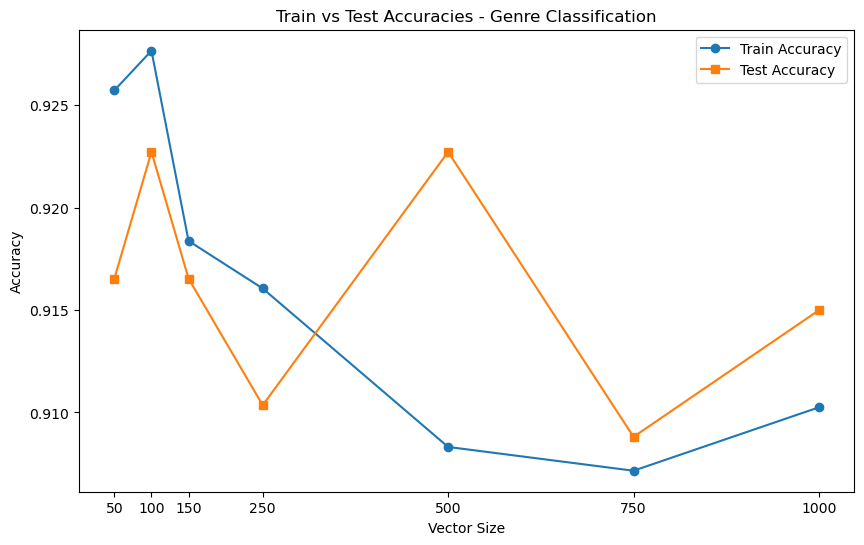

<Figure size 640x480 with 0 Axes>

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(vector_sizes, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(vector_sizes, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Vector Size')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracies - Genre Classification')
plt.xticks(vector_sizes)
plt.legend()
plt.savefig('figures/genre_accuracy.png')
plt.show()
plt.clf()

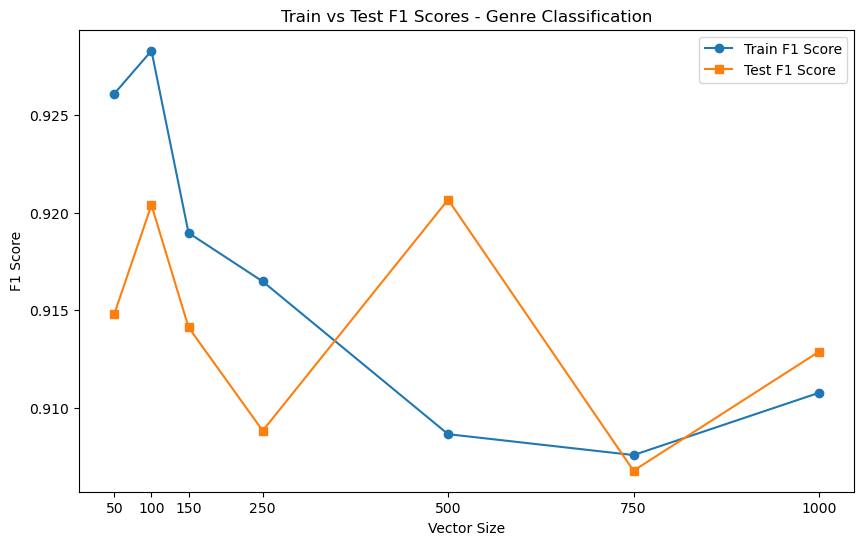

<Figure size 640x480 with 0 Axes>

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(vector_sizes, train_f1, label='Train F1 Score', marker='o')
plt.plot(vector_sizes, test_f1, label='Test F1 Score', marker='s')
plt.xlabel('Vector Size')
plt.ylabel('F1 Score')
plt.title('Train vs Test F1 Scores - Genre Classification')
plt.xticks(vector_sizes)
plt.legend()
plt.savefig('figures/genre_f1.png')
plt.show()
plt.clf()

In [66]:
X, y, vectors = getXy_genre(tagged_genre_data, vector_size=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

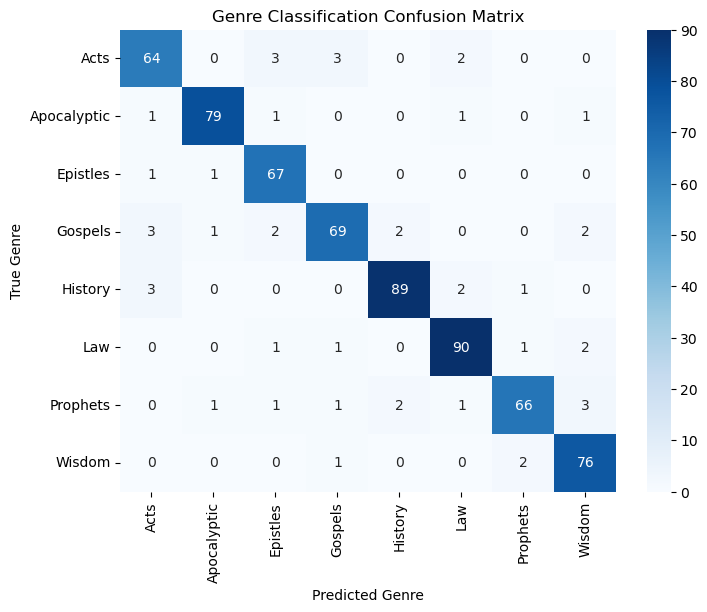

<Figure size 640x480 with 0 Axes>

In [67]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=unique_genres, yticklabels=unique_genres)
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Genre Classification Confusion Matrix')
plt.savefig('figures/genre_cm.png')
plt.show()
plt.clf()

### K-Means Clustering for all data

In [69]:
df = pd.DataFrame(vectors)
df['genre'] = genres
inertias = []
for k in range(1, 21, 2):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df.drop('genre', axis=1))
    inertias.append(kmeans.inertia_)

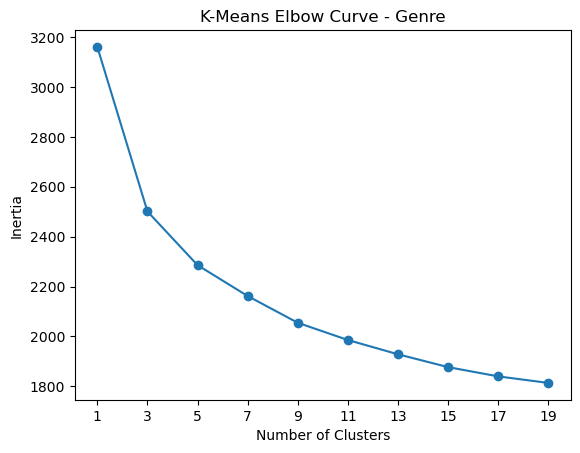

<Figure size 640x480 with 0 Axes>

In [70]:
plt.plot(range(1, 21, 2), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.xticks(range(1, 21, 2))
plt.ylabel('Inertia')
plt.title('K-Means Elbow Curve - Genre')
plt.savefig('figures/genre_elbow.png')
plt.show()
plt.clf()

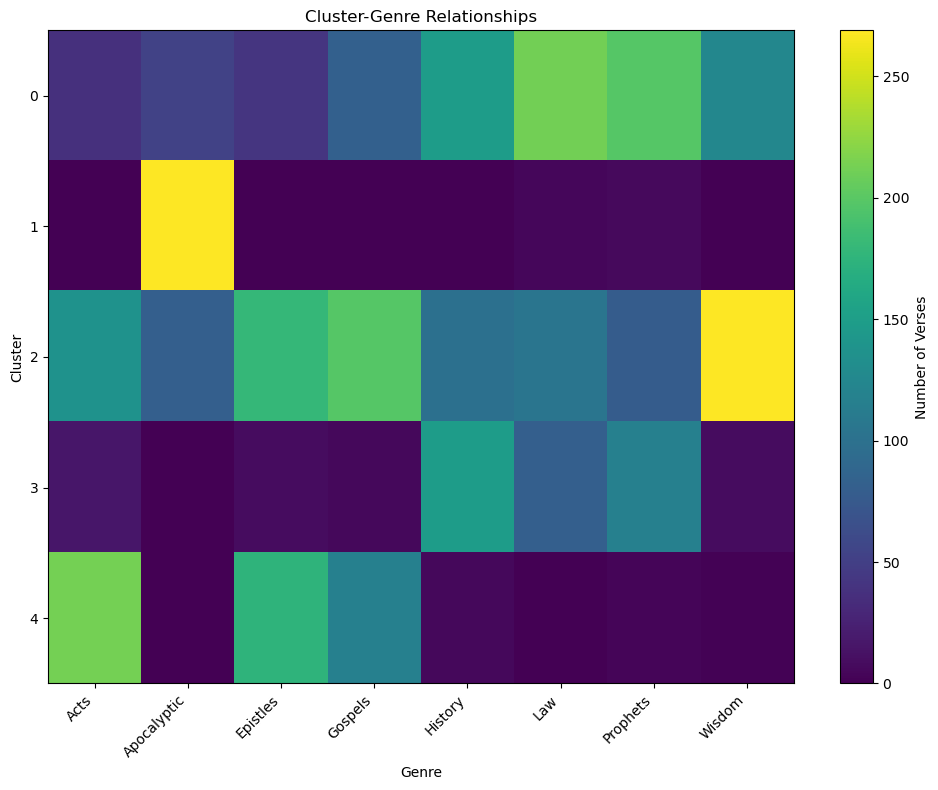

<Figure size 640x480 with 0 Axes>

In [71]:
# perform K-means clustering with the optimal number of clusters for all data
kmeans_all = KMeans(n_clusters=5, random_state=42, n_init=10)
cldf = df.copy()
cldf['cluster_all'] = kmeans_all.fit_predict(cldf.drop('genre', axis=1))

# count the number of verses from each genre in each cluster
cluster_genre_counts = cldf.groupby(['cluster_all', 'genre']).size().unstack(fill_value=0)

# plot cluster-genre relationships
plt.figure(figsize=(10, 8))
plt.imshow(cluster_genre_counts, cmap='viridis', aspect='auto')
plt.colorbar(label='Number of Verses')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.title('Cluster-Genre Relationships')
plt.xticks(range(len(cldf['genre'].unique())), unique_genres, rotation=45, ha='right')
plt.yticks(range(len(cluster_genre_counts)), cluster_genre_counts.index)
plt.tight_layout()
plt.savefig('figures/cluster_genre_heatmap.png')
plt.show()
plt.clf()

### Predict Verse Author

In [72]:
backup_data = backup_data[backup_data['author'].isin(['matthew', 'john', 'luke', 'john mark'])]

In [73]:
author_counts = backup_data['author'].value_counts()
target_count = author_counts.min()

sampled_data = pd.DataFrame(columns=backup_data.columns)

for author, count in author_counts.items():
    if count > target_count:
        # if the genre is overrepresented, sample rows randomly
        sampled_rows = backup_data[backup_data['author'] == author].sample(target_count, random_state=42)
    else:
        # if the genre is already at or below the minimum count, use all rows
        sampled_rows = backup_data[backup_data['author'] == author]
    
    # concatenate the sampled rows
    sampled_data = pd.concat([sampled_data, sampled_rows])

sampled_data.reset_index(drop=True, inplace=True)

In [74]:
data = sampled_data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712 entries, 0 to 2711
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2712 non-null   object
 1   book             2712 non-null   object
 2   chapter          2712 non-null   object
 3   verse            2712 non-null   object
 4   text             2712 non-null   object
 5   book name        2712 non-null   object
 6   testament        2712 non-null   object
 7   genre            2712 non-null   object
 8   genre name       2712 non-null   object
 9   author           2712 non-null   object
 10  number of words  2712 non-null   object
dtypes: object(11)
memory usage: 233.2+ KB
None


In [75]:
# get list of authors corresponding to verse in cleaned_verses list
verses = data["text"].to_list()
authors = data["author"].tolist()

cleaned_verses = [remove_punctuation(verse) for verse in verses]

unique_authors = sorted(set(authors))

In [76]:
# create tagged data for Doc2Vec (authors are tags)
tagged_author_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(author)]) for doc, author in zip(cleaned_verses, authors)]

In [77]:
vector_sizes = [50, 100, 150, 250, 500, 750, 1000]
train_accuracies = []
test_accuracies = []

train_f1 = []
test_f1 = []

for vector_size in vector_sizes:
    print("\nTraining vector_size =", vector_size)
    
    X, y, vectors = getXy_author(tagged_author_data, vector_size=vector_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='macro')
    
    train_accuracies.append(accuracy)
    train_f1.append(f1)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    test_accuracies.append(accuracy)
    test_f1.append(f1)


Training vector_size = 50

Training vector_size = 100

Training vector_size = 150

Training vector_size = 250

Training vector_size = 500

Training vector_size = 750

Training vector_size = 1000


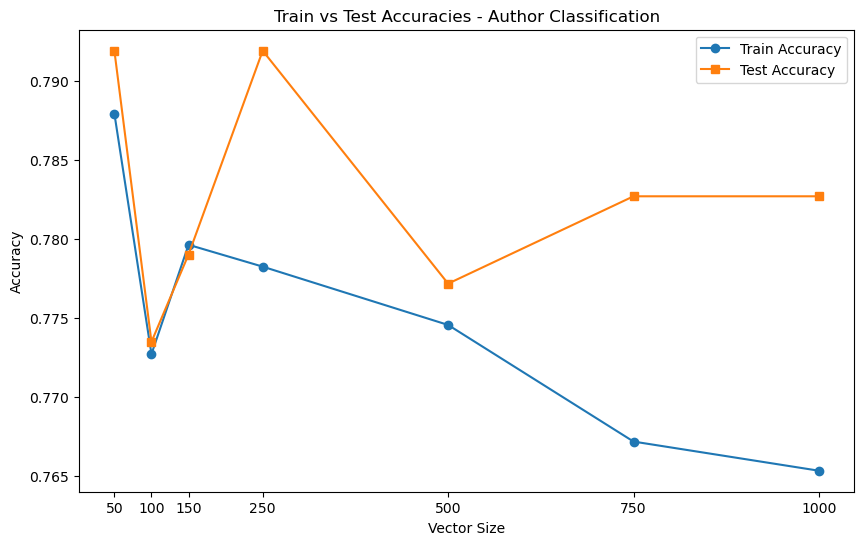

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(vector_sizes, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(vector_sizes, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Vector Size')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracies - Author Classification')
plt.xticks(vector_sizes)
plt.legend()
plt.savefig('figures/author_acc.png')
plt.show()

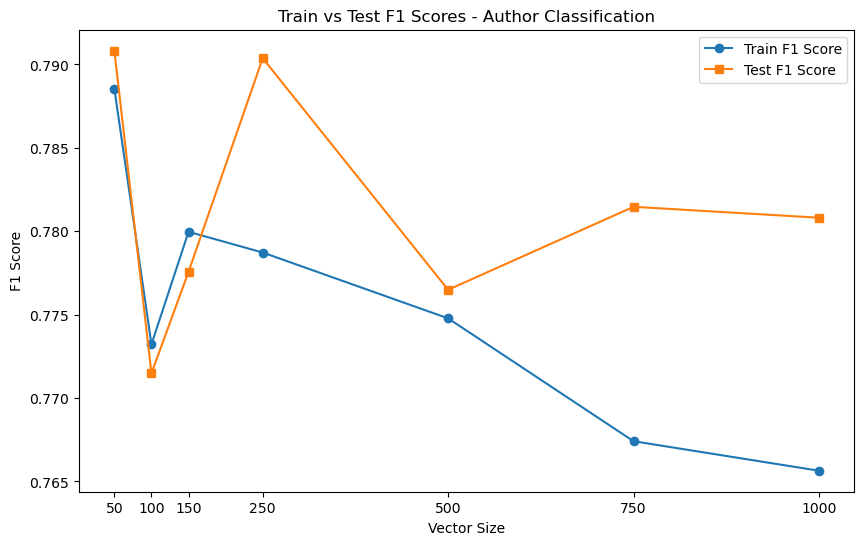

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(vector_sizes, train_f1, label='Train F1 Score', marker='o')
plt.plot(vector_sizes, test_f1, label='Test F1 Score', marker='s')
plt.xlabel('Vector Size')
plt.ylabel('F1 Score')
plt.title('Train vs Test F1 Scores - Author Classification')
plt.xticks(vector_sizes)
plt.legend()
plt.savefig('figures/author_f1.png')
plt.show()

In [80]:
X, y, vectors = getXy_author(tagged_author_data, vector_size=50)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

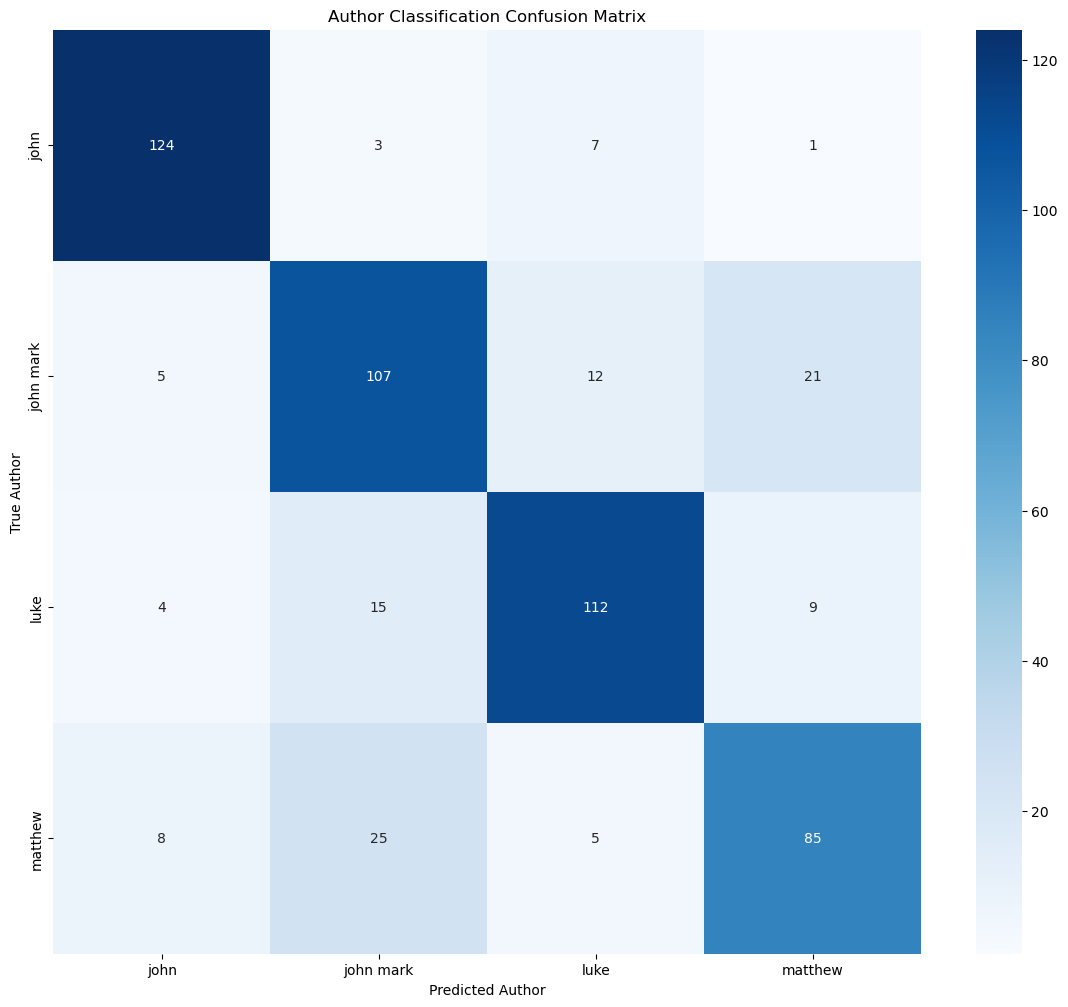

In [81]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=unique_authors, yticklabels=unique_authors)
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.title('Author Classification Confusion Matrix')
plt.savefig('figures/author_cm.png')
plt.show()

In [86]:
df = pd.DataFrame(vectors)
df['author'] = authors

inertias = []
for k in range(1, 21, 2):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df.drop('author', axis=1))
    inertias.append(kmeans.inertia_)

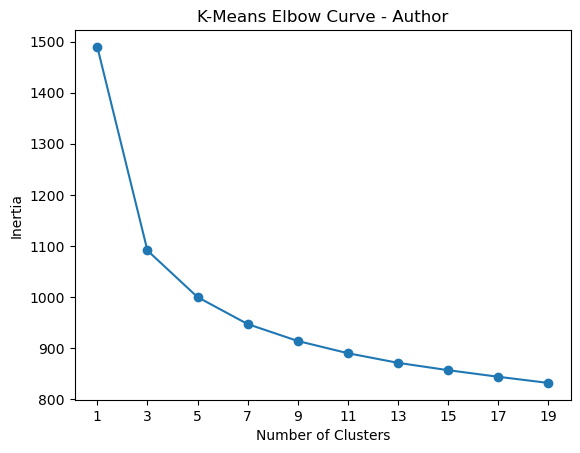

In [87]:
plt.plot(range(1, 21, 2), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.xticks(range(1, 21, 2))
plt.ylabel('Inertia')
plt.title('K-Means Elbow Curve - Author')
plt.savefig('figures/author_elbow.png')
plt.show()

3


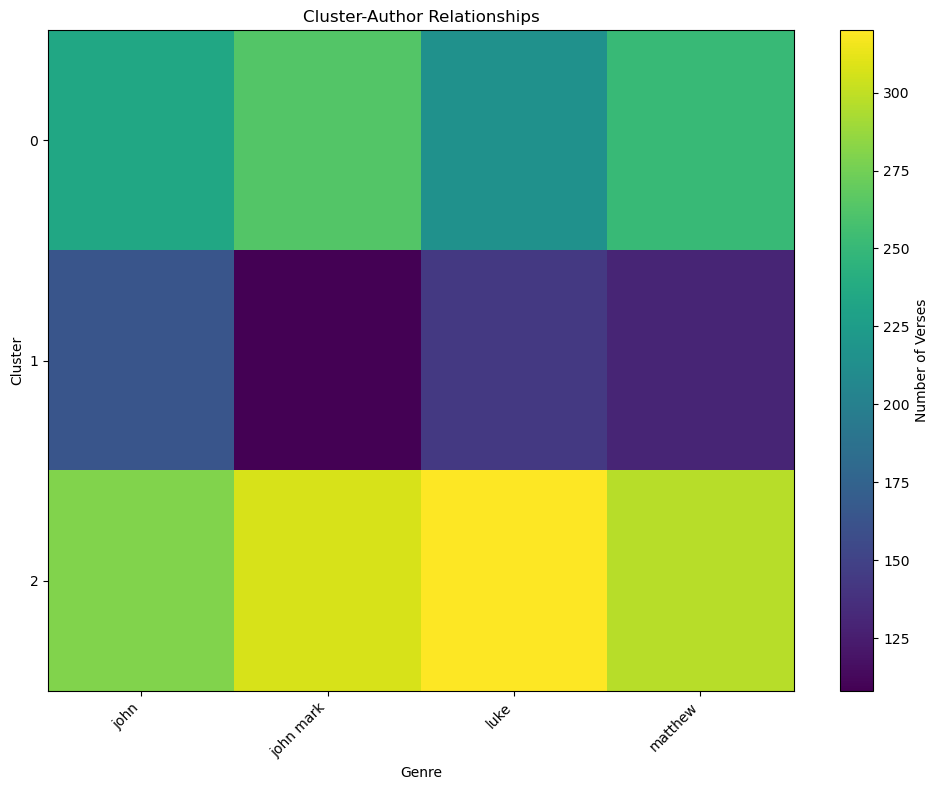

In [89]:
# perform K-means clustering with the optimal number of clusters for all data
kmeans_all = KMeans(n_clusters=3, random_state=42, n_init=10)
cldf = df.copy()
cldf['cluster_all'] = kmeans_all.fit_predict(cldf.drop('author', axis=1))

# count the number of verses from each genre in each cluster
cluster_author_counts = cldf.groupby(['cluster_all', 'author']).size().unstack(fill_value=0)
print(len(cluster_author_counts))

# plot cluster-genre relationships
plt.figure(figsize=(10, 8))
plt.imshow(cluster_author_counts, cmap='viridis', aspect='auto')
plt.colorbar(label='Number of Verses')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.title('Cluster-Author Relationships')
plt.xticks(range(len(cldf['author'].unique())), unique_authors, rotation=45, ha='right')
plt.yticks(range(len(cluster_author_counts)), cluster_author_counts.index)
plt.tight_layout()
plt.savefig('figures/cluster_author_heatmap.png')
plt.show()